# 1. Imports and Set Up

In [1]:
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from scripts.classification_utils import *
from scripts.visualization_utils import *
from scripts.evaluation_utils import *
import csv
import os
from itertools import zip_longest
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, EqualizedOdds, \
    TruePositiveRateParity, FalsePositiveRateParity, ErrorRateParity, BoundedGroupLoss
from fairlearn.metrics import *
from raiwidgets import FairnessDashboard
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0. IMPORTANT--Specify classifier to be trained and dataset

In [2]:
models = {'Decision Tree': 'dt', 'Gaussian Naive Bayes':'gnb','Logistic Regression': 'lgr', 'Gradient_Boosted_Trees': 'gbt'}
#constraints = {'DemograficParity': 'DP', 'DemograficParity': 'EO', 'DemograficParity': 'EOO', 'DemograficParity': 'FPRP', 'DemograficParity': 'ERP'}
#reduction_algorithms = {'Exponential Gradient':'EG','Grid Search':'GS'}

model_name = models['Logistic Regression']

data_path = '../data/synthetic42/Demo-b_Repay-b.csv'
results_path = '../data/results/synthetic_test1/bb/'

weight_idx = 1
testset_size = 0.3


demo_ratio = [[0.5,0.5],[0.5,0.5]] #[B,W] Train,Test
label_ratio = [0.5,0.5] #[N,P] For black Group

balance_test_set = True
set_bound = [70000,30000]

save = True

In [3]:
os.makedirs(f'{results_path}{model_name}', exist_ok=True)


In [4]:
models_dict = {}
overall_results_dict = {}
black_results_dict = {}
white_results_dict = {}
all_types = []
all_scores = []
scores_names = []

# 2. Prepare data

In [5]:
data = get_data(data_path)
x = data[['score', 'race']].values
y = data['repay_indices'].values
print(type(x))

<class 'numpy.ndarray'>


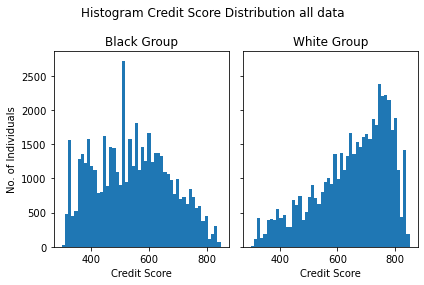

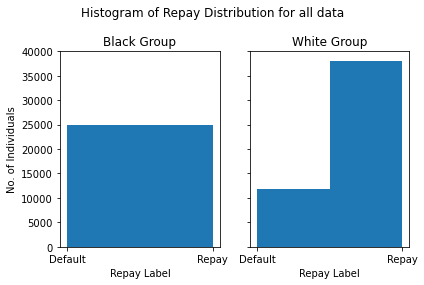

In [6]:
#print(type(data))
#print(data)
visual_scores_by_race(results_path,'all',x)
visual_repay_dist(results_path,'all',x,y)
plt.show()

In [7]:
X_train, X_test, y_train, y_test, race_train, race_test, sample_weight_train, sample_weight_test = prep_data(data, testset_size,demo_ratio, label_ratio,balance_test_set,set_bound, weight_idx)

 Whole set: 100000
Black N/P: 25000 / 25000 White N/P: 11883 / 38117
Training set: 70000
Black N/P: 17586 / 17462 White N/P: 8278 / 26674
Testing set: 14420
Black N/P: 3605 / 3605 White N/P: 3605 / 3605


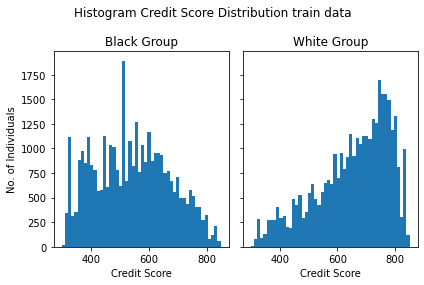

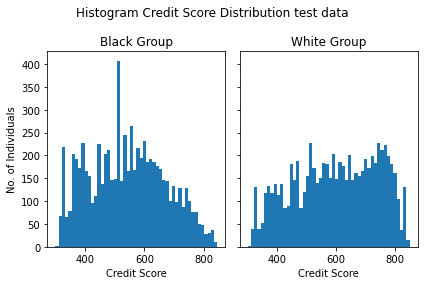

In [8]:
# make histogram of credit scores by race
visual_scores_by_race(results_path,'train',X_train)
visual_scores_by_race(results_path,'test',X_test)

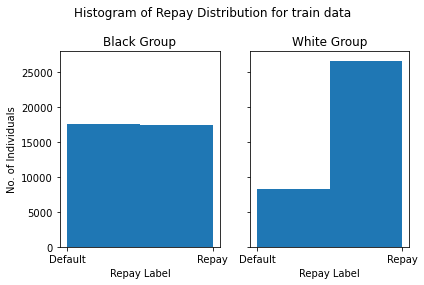

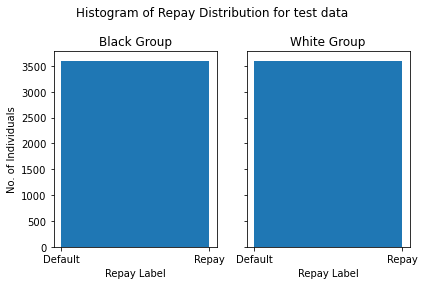

In [9]:
visual_repay_dist(results_path,'train',X_train, y_train)
visual_repay_dist(results_path,'test',X_test,y_test)

In [ ]:
X_test_b = []
X_test_w = []
y_test_b = []
y_test_w = []


for index in range(len(X_test)):
    if race_test[index] == 0:  # black
        X_test_b.append(X_test[index][0])
        y_test_b.append(y_test[index])
    elif race_test[index] == 1:  # white
        X_test_w.append(X_test[index][0])
        y_test_w.append(y_test[index])

In [ ]:
#adding scores to list
T_test_b = ['TP' if e==1 else "TN" for e in y_test_b]
T_test_w = ['TP' if e==1 else "TN" for e in y_test_w]
all_types.extend([T_test_b,T_test_w])
all_scores.extend([X_test_b,X_test_w])
scores_names.extend(['testB', 'testW'])

# 3. Classifier

In [ ]:
print('The classifier trained below is: ', model_name)

results_path += f'{model_name}/'

In [ ]:
classifier = get_classifier(model_name)

## Train classifier and collect predictions
NOTE: atm sample_weight are all 1s

In [ ]:
# Reference: https://www.datacamp.com/community/tutorials/decision-tree-classification-python
np.random.seed(0)

# Train the classifier:
model = classifier.fit(X_train,y_train, sample_weight_train)

# Make predictions with the classifier:
y_predict = model.predict(X_test)

# Scores on test set
test_scores = model.predict_proba(X_test)[:, 1]

### Get new scores by race

In [ ]:
# think: later on I might want to create a sheet just with the TP and FP scores by race specifically
X_unmit_b, X_unmit_w,T_unmit_b, T_unmit_w = get_new_scores(X_test, y_predict, y_test, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_unmit_b,T_unmit_w])
all_scores.extend([X_unmit_b,X_unmit_w])
scores_names.extend(['unmitB', 'unmitW'])

### Evaluation of classifier overall

In [ ]:
# Metrics
models_dict = {"Unmitigated": (y_predict, test_scores)}
get_metrics_df(models_dict, y_test, race_test)

### Cross-validated metrics

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, x, y, cv=5, scoring='f1_weighted')
print(scores)

### Delayed impact calculated
### Fairness Metric Evaluation of classifier
### Evaluation of classifier by race

In [ ]:
constraint_str = 'Un-'
results_overall, results_black, results_white = evaluating_model(constraint_str,X_test,y_test, y_predict, sample_weight_test,race_test)

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} Unmitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
#print(black_results_dict)
#print(white_results_dict)

## Exponentiated Gradient Reduction Alg for Adding Fairness Constraints

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 60em; }</style>"))

### Demographic Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'DP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
### Get new scores by race
X_egDP_b, X_egDP_w,T_egDP_b, T_egDP_w = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_egDP_b, T_egDP_w])
all_scores.extend([X_egDP_b, X_egDP_w])
scores_names.extend(['egdpB', 'egdpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} EG DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Equalized Odds

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'EO', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
X_egEO_b, X_egEO_w,T_egEO_b, T_egEO_w = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_egEO_b, T_egEO_w])
all_scores.extend([X_egEO_b, X_egEO_w])
scores_names.extend(['egeoB', 'egeoW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} EG EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### EOO (True Positive Rate Parity)

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'TPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
X_egEOO_b, X_egEOO_w,T_egEOO_b, T_egEOO_w = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_egEOO_b, T_egEOO_w])
all_scores.extend([X_egEOO_b, X_egEOO_w])
scores_names.extend(['egeooB', 'egeooW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} EG EOO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### False Positive Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'FPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
X_egFPRP_b, X_egFPRP_w,T_egFPRP_b, T_egFPRP_w = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_egFPRP_b, T_egFPRP_w])
all_scores.extend([X_egFPRP_b, X_egFPRP_w])
scores_names.extend(['egfprpB', 'egfprpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} EG FPRP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Error Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'ERP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
X_egERP_b, X_egERP_w,T_egERP_b, T_egERP_w = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_egERP_b, T_egERP_w])
all_scores.extend([X_egERP_b, X_egERP_w])
scores_names.extend(['egerpB', 'egerpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} EG ERP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

## Grid Search Reduction Alg for Adding Fairness Constraints

### Demographic Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'DP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

The next few cells come from: https://github.com/fairlearn/fairlearn/blob/main/notebooks/Binary%20Classification%20with%20the%20UCI%20Credit-card%20Default%20Dataset.ipynb

Note: we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric.

In [ ]:
grid_search_show(mitigator, demographic_parity_difference, y_pred_mitigated, X_test, y_test, race_test, 'DemParityDifference','GS DPD', models_dict, 0.3)

In [ ]:
models_dict.pop('GS DPD')
models_dict

### Get new scores by race

In [ ]:
X_gsDP_b, X_gsDP_w,T_gsDP_b, T_gsDP_w = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_gsDP_b, T_gsDP_w ])
all_scores.extend([X_gsDP_b, X_gsDP_w ])
scores_names.extend(['gsdpB', 'gsdpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Equalized Odds Used

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'EO', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
grid_search_show(mitigator, equalized_odds_difference, y_pred_mitigated, X_test, y_test, race_test, 'EOddsDifference','GS EO', models_dict, 0.3)

In [ ]:
models_dict.pop('GS EO')
models_dict

### Get new scores by race

In [ ]:
X_gsEO_b, X_gsEO_w,T_gsEO_b, T_gsEO_w = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_gsEO_b, T_gsEO_w])
all_scores.extend([X_gsEO_b, X_gsEO_w])
scores_names.extend(['gseoB', 'gseoW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### EOO (True Positive Rate Parity)

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'TPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
grid_search_show(mitigator, true_positive_rate_difference, y_pred_mitigated, X_test, y_test, race_test, 'TPRPDifference','GS TPRP', models_dict, 0.3)

In [ ]:
models_dict.pop('GS TPRP')
models_dict

### Get new scores by race

In [ ]:
X_gsEOO_b, X_gsEOO_w,X_gsEOO_b, X_gsEOO_w = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_gsEOO_b, T_gsEOO_w])
all_scores.extend([X_gsEOO_b, X_gsEOO_w])
scores_names.extend(['gseooB', 'gseooW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS EOO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### False Positive Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'FPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
# NOTE: the below models are the same for DT classifier!!

In [ ]:
grid_search_show(mitigator, false_positive_rate_difference, y_pred_mitigated, X_test, y_test, race_test, 'FPRPDifference','GS FPRP', models_dict, 0.4)

In [ ]:
models_dict.pop('GS FPRP')
models_dict

### Get scores by race

In [ ]:
X_gsFPRP_b, X_gsFPRP_w,T_gsFPRP_b, T_gsFPRP_w = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_gsFPRP_b, T_gsFPRP_w])
all_scores.extend([X_gsFPRP_b, X_gsFPRP_w])
scores_names.extend(['gsfprpB', 'gsfprpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS FPRP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Error Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'ERP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
# Fairlearn doesnt have an erp difference metric for the below
#grid_search_show(gs_erp, error_difference, y_predict, X_test, y_test, race_test, 'ERDifference','GS ERP', models_dict, 0.3)
#models_dict.pop('GS FPRP')
#models_dict

### Get scores by race

In [ ]:
X_gsERP_b, X_gsERP_w,T_gsERP_b, T_gsERP_w = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_gsERP_b, T_gsERP_w])
all_scores.extend([X_gsERP_b, X_gsERP_w])
scores_names.extend(['gserpB', 'gserpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS ERP Mitigated'
print(run_key)
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

# 4. Save results to csv files

In [ ]:
# To use below!!
if save == True:
    overall_fieldnames = ['Run', 'Acc', 'ConfMatrix','F1micro', 'F1weighted','F1binary', 'SelectionRate', 'TNR rate', 'TPR rate', 'FNER', 'FPER', 'DIB','DIW', 'DP Diff', 'EO Diff', 'TPR Diff', 'FPR Diff', 'ER Diff']
    byrace_fieldnames = ['Run', 'Acc', 'ConfMatrix','F1micro', 'F1weighted','F1binary', 'SelectionRate', 'TNR rate', 'TPR rate', 'FNER', 'FPER', 'DI']
    save_dict_in_csv(overall_results_dict, overall_fieldnames,  results_path+model_name+'_overall_results.csv')
    save_dict_in_csv(black_results_dict, byrace_fieldnames,  results_path+model_name+'_black_results.csv')
    save_dict_in_csv(white_results_dict, byrace_fieldnames,  results_path+model_name+'_white_results.csv')

In [ ]:
if save == True:
    # Save overall score results
    columns_data_scores = zip_longest(*all_scores)
    columns_data_types = zip_longest(*all_types)

    with open(results_path+model_name+'_all_scores.csv',mode='w') as f:
            writer = csv.writer(f)
            writer.writerow(scores_names)
            writer.writerows(columns_data_scores)
            f.close()
        with open(results_path+model_name+'_all_types.csv',mode='w') as f:
            writer = csv.writer(f)
            writer.writerow(scores_names)
            writer.writerows(columns_data_types)
            f.close()